<a href="https://colab.research.google.com/github/zapata-git/Evaluacion-de-seguros-de-vida-para-Prudential-/blob/main/05_Curvas_de_Aprendizaje_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ProyectoIA_Seguros_Prudential**
*Este conjunto de datos contiene información sobre solicitantes de seguros para la compañía Prudential. Se busca crear un algoritmo que perfile solicitantes en una escala de 8 niveles.*

*El conjunto de datos proporcionado contiene variables que describen los atributos de los solicitantes de seguros de vida. La tarea consiste en predecir la variable "Response" para cada ID en el conjunto de prueba. "Response" es una medida ordinal de riesgo que tiene 8 niveles.*

---




#Preparación de datos.
Importamos las bibliotecas necesarias y cargamos el conjunto de datos:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
#Algunas advertencias que queremos evitar
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Instalación de Jovian y Kaggle mediante pip

* El paquete jovian se utiliza para guardar y compartir proyectos de ciencia de datos en línea.

* El paquete kaggle proporciona una API de línea de comandos para interactuar con Kaggle, una plataforma en línea para competiciones de ciencia de datos y conjuntos de datos.

In [ ]:
!pip install jovian --upgrade --quiet
!pip install -q kaggle

In [ ]:
import jovian

In [ ]:
#PARA EJECUTAR ESTA LÍNEA, EN EL COMPUTADOR QUE SE EJECUTE DEBE HABER UNA COPIA DEL JSON WEB TOKEN
#DESCARGABLE DESDE LA PÁGINA DE UNA CUENTA DE KAGGLE EN https://www.kaggle.com/settings/account?...
#ESTE JSON WEB TOKEN ES PERSONAL DE CADA CUENTA Y SIRVE COMO IDENTIFICADOR DE ACCESO.
#CARGUE EL JSON QUE USTED DESCARGÓ DE SU CUENTA DE KAGGLE
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carlosozapata","key":"1ea90523afd866a234b17caeb4677869"}'}

#Extracción de los archivos del conjunto de datos descargados desde Kaggle

* El conjunto de datos descargado ya contiene separados los datos de train y de test.

* Los archivos quedan almacenados en el entorno de ejecución de Google Colab siempre y cuando se haya autorizado el acceso de la cuenta de Google a este. Esto se debió realizar en bloques de código anteriores.

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list

In [ ]:
#Para descargar el conjunto de datos desde Kaggle al drive local de Google
!kaggle competitions download 'prudential-life-insurance-assessment'


prudential-life-insurance-assessment.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Para descargar el conjunto de datos desde Kaggle al drive local de Google
!kaggle competitions download 'prudential-life-insurance-assessment'

prudential-life-insurance-assessment.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Para descomprimir los archivos .zip que haya y guardarlos en el entorno de ejecución
import os
from zipfile import ZipFile 
  
#Se indica el nombre del archivo  traído desde Kaggle
file = "prudential-life-insurance-assessment.zip"
  
#Se abre el archivo en modo lectura
with ZipFile(file, 'r') as zip:
  
    #Se extraen todos los archivos
    print('Extracción de archivos en proceso...') 
    zip.extractall() 
    print('Extracción terminada')

%cd "/content/"

for archivo in os.listdir():
  if archivo.endswith(".zip"):
    with ZipFile(archivo, 'r') as zip_ref:
      zip_ref.extractall("/content/")



Extracción de archivos en proceso...
Extracción terminada
/content


In [ ]:
#Se declara el conjunto de datos
datos = pd.read_csv("/content/train.csv")

#Preprocesado.

Se llenan los valores faltantes con la moda si se trata de variables categóricas y la mediana si se trata de variables numéricas.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# Realizar el preprocesamiento de los datos
# Eliminar la columna "Response" del conjunto de entrenamiento y las columnas "Id" de ambos conjuntos entrenamiento y prueba
#Definir la columna "Response" como el y de entrenamiento y restarle 1 a todos los valores en ella para que la red neuronal pueda indexar
X_train = datos.drop(columns = ['Id', 'Response'])
y_train = datos['Response']
y_train = y_train.subtract(1)

# Imputar los valores faltantes en los datos numéricos con la mediana
num_cols = X_train.select_dtypes(include='number').columns
num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])

# Imputar los valores faltantes en los datos categóricos con la moda
cat_cols = X_train.select_dtypes(include='object').columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])

#Se aplica one-hot-encoding a los datos de entrenamiento (X_train) y a los datos de prueba (X_test)
ohe = OneHotEncoder()
array_categorias = ohe.fit_transform(X_train[['Product_Info_2']]).toarray()
etiqu_categorias = ohe.categories_
categorias_en_columnas_ohe = pd.DataFrame(array_categorias, columns = etiqu_categorias)
X_train = pd.concat([X_train, categorias_en_columnas_ohe], axis =1)
X_train = X_train.drop(columns = ['Product_Info_2'])
X_train.rename(columns=''.join, inplace=True)

#Evaluación de desempeño a partir de curvas de aprendizaje
Se pretende evaluar el desempeño de dos modelos supervisados ya abordados previamente: Redes neuronales y random forest.

In [ ]:
#Proceso de normalización de los datos. Util para algunos métodos de predicción, excepto random forest, en el cuál no redunda en mucha utilidad
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_columnas = X_train.columns.tolist()
X_train_escalado = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_escalado, columns = X_train_columnas)

In [ ]:
#Se recurre a la librería Tensorflow

import tensorflow as tf
from sklearn.model_selection import train_test_split


#Se define la cantidad de etiquetas de salida (nc) y la cantidad de neuronas en la capa de entrada igua a la cantidad de columnas
#m = número de filas, n = número de columnas
#nc = cantidad de clases, en este caso, 8 clases
nc = 8
m = X_train_scaled.shape[0]
n = X_train_scaled.shape[1]


#Se resta 1 a todos los valores en y_train para que la red neuronal pueda indexar
y_train = datos['Response']
y_train = y_train.subtract(1)

X_tr, X_ts, y_tr, y_ts = train_test_split(X_train_scaled, y_train, test_size=0.3, stratify=y_train, random_state=42)

#Se definen la cantidad de unidades (h1, h2) para cada capa oculta
#h1 = cantidad de neuronas en la primera capa oculta
#h2 = cantidad de neuronas en la segunda capa oculta
h1 = np.random.randint(5)+5
h2 = np.random.randint(5)+5

model = tf.keras.Sequential(
      [
        tf.keras.layers.Dense(h1, activation='tanh', dtype=tf.float32),
        tf.keras.layers.Dense(h2, activation='tanh', dtype=tf.float32),
        tf.keras.layers.Dense(8, activation='sigmoid', dtype=tf.float32)
      ]
        )
model.build(input_shape=[None, n])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = .5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_tr.to_numpy(), y_tr.to_numpy(), validation_data = (X_ts, y_ts), epochs = 3, batch_size = 1)

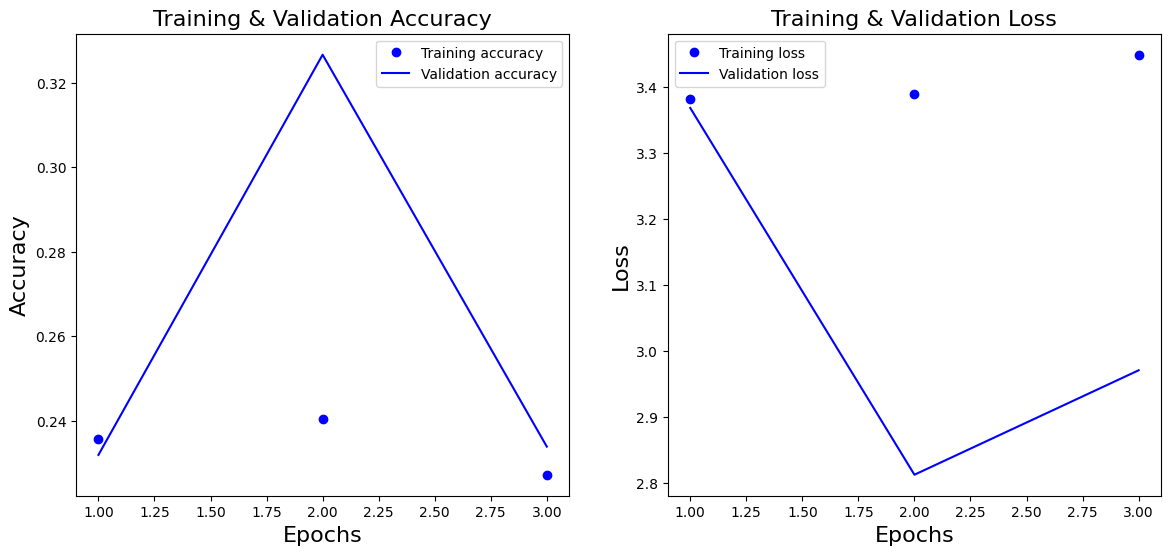

In [ ]:
import matplotlib.pyplot as plt
 
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

#Se grafica el accuracy del modelo vs épocas

ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Se grafica la pérdida vs épocas

ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clasificador_rf = RandomForestClassifier(n_estimators=80)

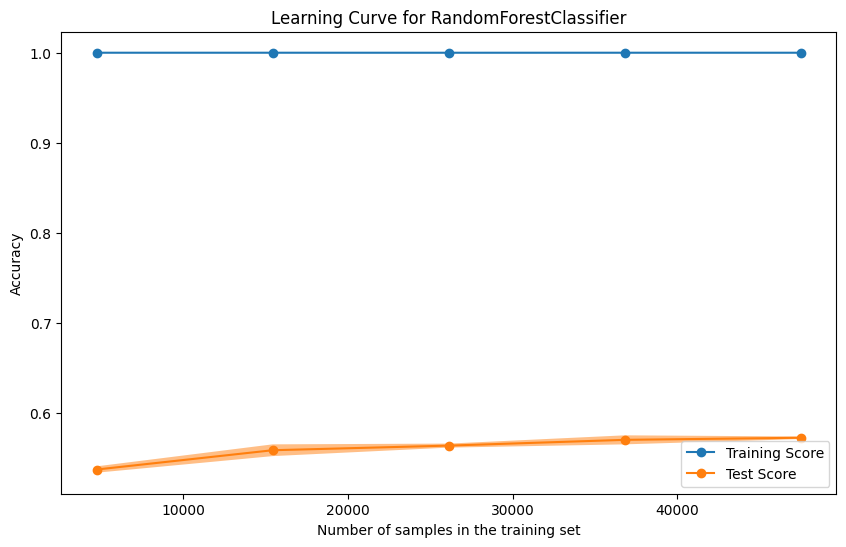

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

y_train = datos['Response']
fig, ax = plt.subplots(figsize=(10, 6))

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=2, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

estimator = clasificador_rf

LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

plt.show()
